In [1]:
import importlib
import os
import sys
sys.path.append(os.path.join('..'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from disruptsc.parameters import Parameters
from disruptsc.model.model import Model
import disruptsc.paths as paths
import disruptsc.network.transport_network

In [4]:
scope = "ECA"
parameters = Parameters.load_parameters(paths.PARAMETER_FOLDER, scope)
parameters.export_files = False
parameters.adjust_logging_behavior(export_log_file=False)
model = Model(parameters)

In [5]:
import disruptsc.network.transport_network
from disruptsc.network.transport_network import TransportNetwork

In [6]:
model.setup_transport_network(True)

2025-02-07 10:56:38,858 - root - INFO - Transport network generated from temp file.
2025-02-07 10:56:38,985 - root - INFO - Total length of transport network is: 254197 km
2025-02-07 10:56:38,986 - root - INFO - maritime: 93721 km
2025-02-07 10:56:38,987 - root - INFO - multimodal: 4 km
2025-02-07 10:56:38,987 - root - INFO - railways: 11827 km
2025-02-07 10:56:38,988 - root - INFO - roads: 148646 km
2025-02-07 10:56:38,992 - root - INFO - Nb of nodes: 11244, nb of edges: 15326


In [7]:
model.setup_agents(True)

2025-02-07 10:56:39,270 - root - INFO - Firms, households, and countries generated from temp file.
2025-02-07 10:56:39,271 - root - INFO - Nb firms: 3668
2025-02-07 10:56:39,272 - root - INFO - Nb households: 49
2025-02-07 10:56:39,272 - root - INFO - Nb countries: 12


In [8]:
from disruptsc.network.mrio import Mrio
mrio = Mrio.load_mrio_from_filepath(parameters.filepaths['mrio'], "kUSD")
region_sector_present = list(model.firms.get_properties('region_sector', output_type="set"))
#mrio.get_tech_coef_dict(threshold=0.1, selected_region_sectors=region_sector_present)

In [16]:
model.setup_sc_network(False)

2025-02-07 11:10:25,808 - root - INFO - The supply chain graph is being created. nb_suppliers_per_input: 3
2025-02-07 11:10:25,810 - root - INFO - Households are selecting their retailers (domestic B2C flows and import B2C flows)
2025-02-07 11:10:28,110 - root - INFO - Exporters are being selected by purchasing countries (export B2B flows)
2025-02-07 11:10:28,110 - root - INFO - and trading countries are being connected (transit flows)
2025-02-07 11:10:28,759 - root - INFO - Firms are selecting their domestic and international suppliers (import B2B flows) (domestic B2B flows). Weight localisation is 1
2025-02-07 11:10:31,840 - root - INFO - There are 664 firms without clients. Removing associated links
2025-02-07 11:10:31,852 - root - INFO - There are 701 firms without clients. Removing associated links
2025-02-07 11:10:31,858 - root - INFO - There are 708 firms without clients. Removing associated links
2025-02-07 11:10:31,863 - root - INFO - There are 711 firms without clients. Remov

{}


PicklingError: Can't pickle <class 'disruptsc.network.sc_network.ScNetwork'>: it's not the same object as disruptsc.network.sc_network.ScNetwork

In [10]:
model.set_initial_conditions()

2025-02-06 15:19:48,902 - root - INFO - Setting initial conditions to input-output equilibrium


In [11]:
model.setup_logistic_routes(True)

2025-02-06 15:20:03,650 - root - INFO - Logistic routes generated from temp file.


In [39]:
model.sc_network.number_of_edges()

[autoreload of disruptsc.model.model failed: Traceback (most recent call last):
  File "C:\Users\Celian\miniforge3\envs\dsc\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Celian\miniforge3\envs\dsc\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "C:\Users\Celian\miniforge3\envs\dsc\Lib\importlib\__init__.py", line 129, in reload
    _bootstrap._exec(spec, module)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 1018, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1156, in get_code
  File "<frozen importlib._bootstrap_external>", line 1086, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "C:\Users\Celian\OneDrive\WorldB

57071

In [36]:
model.sc_network.out_edges(model.countries['China'])

OutEdgeDataView([(<disruptsc.agents.country.Country object at 0x000001CCAA7E9C70>, <disruptsc.agents.firm.Firm object at 0x000001CCA5D7C910>), (<disruptsc.agents.country.Country object at 0x000001CCAA7E9C70>, <disruptsc.agents.firm.Firm object at 0x000001CCA5ABF750>), (<disruptsc.agents.country.Country object at 0x000001CCAA7E9C70>, <disruptsc.agents.firm.Firm object at 0x000001CCA5B72D50>), (<disruptsc.agents.country.Country object at 0x000001CCAA7E9C70>, <disruptsc.agents.firm.Firm object at 0x000001CCA5ABC7D0>), (<disruptsc.agents.country.Country object at 0x000001CCAA7E9C70>, <disruptsc.agents.firm.Firm object at 0x000001CCA5B71590>), (<disruptsc.agents.country.Country object at 0x000001CCAA7E9C70>, <disruptsc.agents.firm.Firm object at 0x000001CCA5B707D0>), (<disruptsc.agents.country.Country object at 0x000001CCAA7E9C70>, <disruptsc.agents.firm.Firm object at 0x000001CCA5B734D0>), (<disruptsc.agents.country.Country object at 0x000001CCAA7E9C70>, <disruptsc.agents.firm.Firm object 

In [35]:
ll = model.firms.get_properties("clients", "list")
ll = [list(d.keys()) for d in ll]
"China" in [item for sublist in ll for item in sublist]

False

<AxesSubplot: >

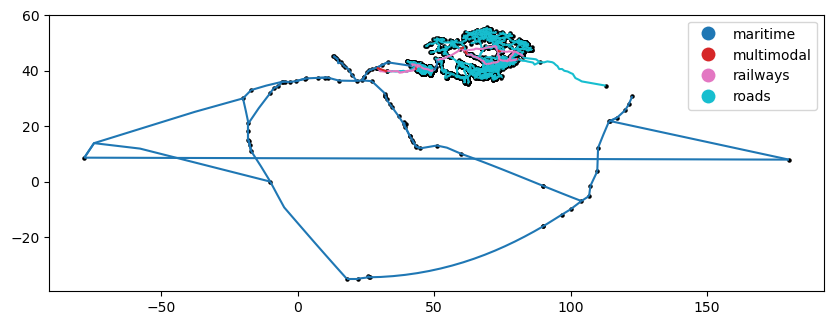

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
model.transport_edges.plot(column="type", legend=True, ax=ax, cmap="tab10")  # Use a colormap like "tab10"
model.transport_nodes.plot(ax=ax, color="black", markersize=5, label="Nodes")

In [34]:
model.transport_network.nodes[0]['geometry'].y

40.68659770997405

In [68]:
all_od_points = set(model.firm_table['od_point'].unique())
print(f"There are {len(all_od_points)} od points")

There are 587 od points


In [75]:
nx.has_path(model.transport_network, 4117, 4118)

True

In [62]:
nx.has_path(model.transport_network, 10236, 7584)

False

In [33]:
from itertools import combinations, product
import networkx as nx
from tqdm import tqdm


def identify_unconnected_pairs(graph, pairs):
    print(f"There are {len(pairs)} pairs of nodes")
    pairs_not_connected = []
    for node1, node2 in tqdm(pairs, desc="Processing pairs", total=len(pairs)):
        if not nx.has_path(model.transport_network, node1, node2):
            pairs_not_connected.append((node1, node2))
    print(f"There are {len(pairs_not_connected)} disconnected pairs")
    return pairs_not_connected


def identify_unconnected_pairs_two_sets(graph, set1, set2):
    pairs = list(product(set1, set2))
    return identify_unconnected_pairs(graph, pairs)


def identify_unconnected_pairs_one_set(graph, set1):
    pairs = list(combinations(set1, 2))
    return identify_unconnected_pairs(graph, pairs)

In [69]:
countries_not_connected = identify_unconnected_pairs_one_set(model.transport_network, set(model.countries.get_properties('od_point').values()))

There are 28 pairs of nodes


Processing pairs: 100%|██████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1559.66it/s]

There are 0 disconnected pairs


In [70]:
countries_households_not_connected = identify_unconnected_pairs_two_sets(model.transport_network, 
                                                              set(model.countries.get_properties('od_point').values()),
                                                              set(model.household_table['od_point'].unique())
                                                             )

There are 48 pairs of nodes


Processing pairs: 100%|███████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 501.33it/s]

There are 0 disconnected pairs


In [71]:
firms_households_not_connected = identify_unconnected_pairs_two_sets(model.transport_network, 
                                                                     set(model.firm_table['od_point'].unique()),
                                                                     set(model.household_table['od_point'].unique())
                                                                    )

There are 3522 pairs of nodes


Processing pairs: 100%|███████████████████████████████████████████████████████████| 3522/3522 [00:09<00:00, 357.34it/s]

There are 6 disconnected pairs


In [76]:
firms_countries_not_connected = identify_unconnected_pairs_two_sets(model.transport_network, 
                                                                     set(model.firm_table['od_point'].unique()),
                                                                     set(model.countries.get_properties('od_point').values())
                                                                    )

There are 4696 pairs of nodes


Processing pairs: 100%|███████████████████████████████████████████████████████████| 4696/4696 [00:10<00:00, 453.88it/s]

There are 8 disconnected pairs


In [78]:
firms_not_connected = identify_unconnected_pairs_one_set(model.transport_network, set(model.firm_table['od_point'].unique()))

There are 171991 pairs of nodes


Processing pairs: 100%|███████████████████████████████████████████████████████| 171991/171991 [08:12<00:00, 349.52it/s]

There are 586 disconnected pairs


In [84]:
# get nodes disconnected to many pairs
import pandas as pd
df = pd.DataFrame(firms_not_connected)
print(str(df[0].value_counts().iloc[:30].index.to_list()))
print(pd.concat([df[0]]).value_counts().index)
pd.concat([df[0], df[1]]).value_counts().iloc[:10]

[9887, 3180, 9377, 9379, 9378, 3233, 7316, 7314, 3207, 9348, 1148, 1142, 3184, 9327, 3174, 9385, 7267, 9315, 7257, 1109, 9299, 7250, 1095, 1092, 9282, 9255, 1058, 9243, 3241, 9398]
Int64Index([ 9887,  3180,  9377,  9379,  9378,  3233,  7316,  7314,  3207,
             9348,
            ...
             4593,  4589,  6637, 10731,  4583,  4582,  4572,  4570,  4569,
              786],
           dtype='int64', length=472)


9887    586
8194      1
5561      1
5554      1
3507      1
1460      1
5557      1
5556      1
1463      1
9660      1
dtype: int64

In [ ]:
country_firm_pairs = product(set(model.country_table['od_point'].unique()), set(model.firm_table['od_point'].unique()))
country_firm_not_connected = []
for country, firm in tqdm(country_firm_pairs, desc="Processing pairs"):
    if not G.has_edge(country, firm):
        country_firm_not_connected.append((country, firm))

Processing node pairs: 53642it [03:19, 252.11it/s] 

In [24]:
country_household_pairs = product(set(model.country_table['od_point'].unique()), set(model.household_table['od_point'].unique()))
country_household_not_connected = []
for country, firm in tqdm(country_household_pairs, desc="Processing pairs"):
    if not G.has_edge(country, firm):
        country_household_not_connected.append((country, firm))

AttributeError: 'Model' object has no attribute 'country_table'

In [ ]:
firm_household_pairs = product(set(model.firm_table['od_point'].unique()), set(model.household_table['od_point'].unique()))
firm_household_not_connected = []
for country, firm in tqdm(firm_household_pairs, desc="Processing pairs"):
    if not G.has_edge(country, firm):
        firm_household_not_connected.append((country, firm))

Processing node pairs: 53642it [03:19, 252.11it/s] 

In [ ]:
model.transport_edges

In [19]:
events = model.parameters.events
events[0]

{'type': 'transport_disruption',
 'description_type': 'edge_attributes',
 'attribute': 'disruption',
 'values': ['flood_1in1000_UZB'],
 'start_time': 1,
 'duration': 1}

In [20]:
from disruptsc.disruption.disruption import DisruptionList, TransportDisruption
DisruptionList.from_events_parameter(model.parameters.events,  model.parameters.monetary_units_in_model,
                                                                    model.transport_edges, model.firm_table,
                                                                    model.firms)

DisruptionList([EventDict(start_time=1, data={})])

In [22]:
disruption_object = TransportDisruption.from_edge_attributes(
                        edges=model.transport_edges,
                        attribute=events[0]['attribute'],
                        values=events[0]['values']
                    )
disruption_object

EventDict(start_time=1, data={})

In [25]:
condition = [model.transport_edges[events[0]['attribute']].str.contains(value) for value in events[0]['values']]
condition

[index
 0       None
 1       None
 2       None
 3       None
 4       None
         ... 
 1374     NaN
 1375     NaN
 1376     NaN
 1377     NaN
 1378     NaN
 Name: disruption, Length: 1379, dtype: object]

In [ ]:

condition = pandas.concat(condition, axis=1)
condition = condition.any(axis=1)